In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
os.chdir(r'''D:\Coursera_ML\Final Project''')

### 1. Загрузка данных.

In [2]:
data=pd.read_excel(r'''Grouped_data.xlsx''')

In [3]:
identifiers=pd.read_csv(r'''regions.csv''',engine='python',sep=';')

In [4]:
sum_trips=data.groupby('region')[['N_trips']].sum().reset_index()

In [5]:
print('Число ячеек из которых не было совершено ни одной поездки - {}.'.format(2500-len(sum_trips)))

Число ячеек из которых не было совершено ни одной поездки - 1283.


### 2. Отрисовка статической карты.

In [6]:
ESB_region=1231
ESB_x=-73.985428
ESB_y=40.748817

In [7]:
from mpl_toolkits.basemap import Basemap
from matplotlib import pyplot as plt

In [8]:
diflat=(-74.25559-73.70001)/2
diflon=(40.91553+40.49612)/2 

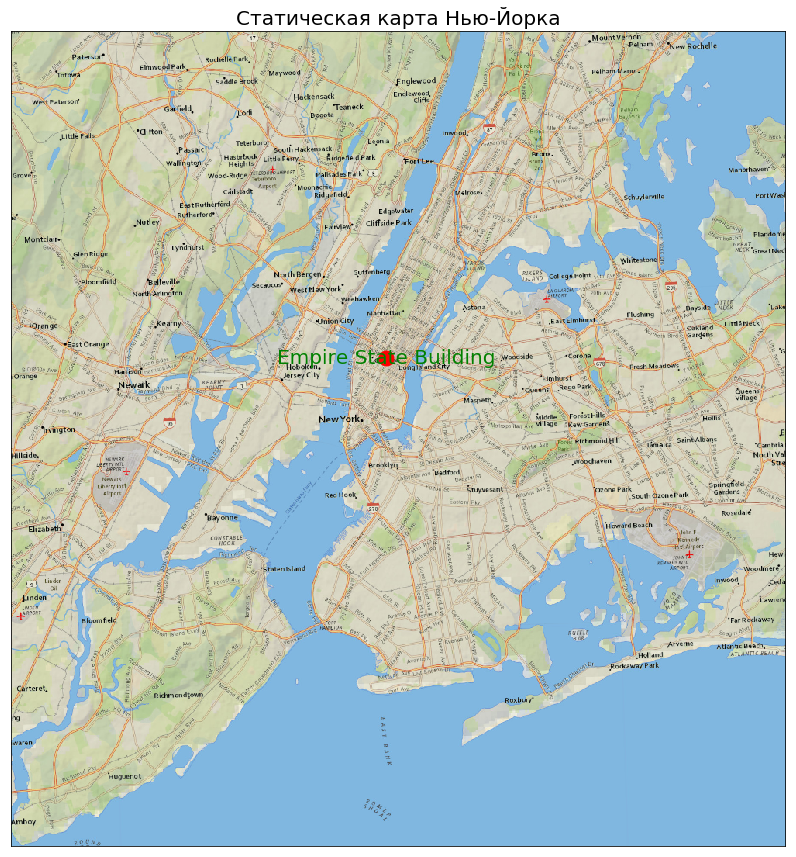

In [9]:
plt.figure(figsize=(15,15))
maps = Basemap(llcrnrlat=40.49612 ,urcrnrlat=40.91553 ,llcrnrlon=-74.25559,urcrnrlon=-73.70001,epsg=2261)
maps.arcgisimage(service='NatGeo_World_Map', xpixels = 1000)
x,y=maps(ESB_x,ESB_y)
maps.plot(x,y,'ro',markersize=15)
plt.text(x,y,'Empire State Building',fontsize=20,ha='center',va='center',color='green')
plt.title('Статическая карта Нью-Йорка',fontsize=20)
plt.show()

### 3. Отрисовка статической карты с плотностью суммарного числа поездок.

In [10]:
join_by_region=pd.merge(identifiers,sum_trips,on=['region'],how='outer').fillna(0)
join_by_region['mean_lat']=(join_by_region['north']+join_by_region['south'])/2
join_by_region['mean_lon']=(join_by_region['east']+join_by_region['west'])/2

In [11]:
from matplotlib.colors import LogNorm

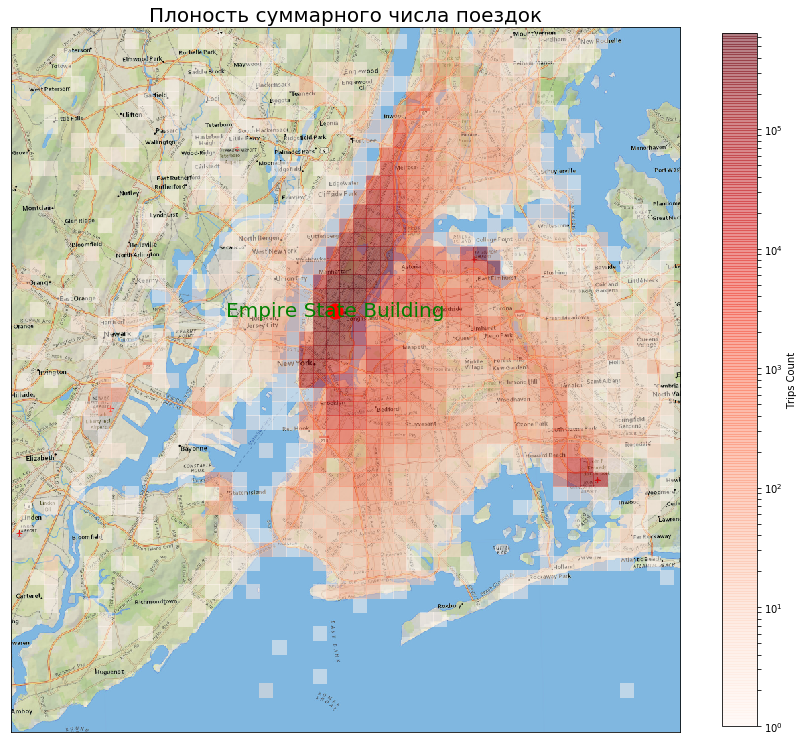

In [12]:
fig = plt.figure(figsize=(15,15))
maps = Basemap(llcrnrlat=40.49612 ,urcrnrlat=40.91553 ,llcrnrlon=-74.25559,urcrnrlon=-73.70001,epsg=2261)

maps.arcgisimage(service='NatGeo_World_Map', xpixels = 1000)
maps.pcolormesh(join_by_region.mean_lon.unique(), join_by_region.mean_lat.unique()
                , join_by_region.N_trips.values.reshape(50,50).T
               ,norm=LogNorm(vmin=1, vmax=np.max(join_by_region.N_trips))
               ,latlon=True, alpha=0.5, cmap='Reds')

x,y=maps(ESB_x,ESB_y)
maps.plot(x,y,'ro',markersize=15)
plt.text(x,y,'Empire State Building',fontsize=20,ha='center',va='center',color='green')

plt.colorbar(orientation='vertical', shrink=0.85, label='Trips Count')
plt.title('Плоность суммарного числа поездок',fontsize=20)
plt.show()  

### 4. Отрисовка интерактивной карты.

In [13]:
import folium
from IPython.core.display import *
SOL_x=-74.044502
SOL_y=40.689247

In [63]:
maps = folium.Map(location=[diflon,diflat],width=1000, height=1000,
               zoom_start=12)
folium.Marker([SOL_y, SOL_x]).add_to(maps)
display(HTML(maps._repr_html_()))


### 5. Отрисовка интерактивной карты с плоностью среднего числа поездок в час.

In [64]:
join_by_region['N_trips_mean']=join_by_region['N_trips']/24/31

In [65]:
from matplotlib.colors import  rgb2hex,Normalize, LogNorm

In [66]:
from matplotlib.cm import ScalarMappable

In [67]:
maps = folium.Map(location=[diflon,diflat],
                   width=1000, height=1000,
               zoom_start=12)
vals=join_by_region['N_trips_mean'].values.reshape(50,50).T
log_norm = LogNorm(vmin=0.01, 
               vmax=np.max(vals))
mapper = ScalarMappable(norm=log_norm, cmap='Reds')

for ind_lat, lat in enumerate(join_by_region.south.unique()[:-1]):
    for ind_lon, lon in enumerate(join_by_region.west.unique()[:-1]):
        color = rgb2hex(mapper.to_rgba(vals[ind_lat][ind_lon])[:3])
        folium.Rectangle(bounds=((lat, lon), 
                                 (join_by_region.south.unique()[ind_lat+1], join_by_region.west.unique()[ind_lon+1])),
                         color=color,
                         opacity=0.3,
                         weight=1,
                         fill_opacity=0.5,
                         fill_color=color).add_to(maps)
display(HTML(maps._repr_html_()))

### 6. Отрисовка интерактивной карты с плоностью полсе очистки данных.

In [68]:
join_by_region['N_trips_mean']=join_by_region['N_trips_mean'].apply(lambda x: 0*(x<5)+x*(x>=5))

In [69]:
maps = folium.Map(location=[diflon,diflat],
                   width=1000, height=1000,
               zoom_start=12)
vals=join_by_region['N_trips_mean'].values.reshape(50,50).T
log_norm = LogNorm(vmin=0.01, 
               vmax=np.max(vals))
mapper = ScalarMappable(norm=log_norm, cmap='Reds')

for ind_lat, lat in enumerate(join_by_region.south.unique()[:-1]):
    for ind_lon, lon in enumerate(join_by_region.west.unique()[:-1]):
        color = rgb2hex(mapper.to_rgba(vals[ind_lat][ind_lon])[:3])
        folium.Rectangle(bounds=((lat, lon), 
                                 (join_by_region.south.unique()[ind_lat+1], join_by_region.west.unique()[ind_lon+1])),
                         color=color,
                         opacity=0.3,
                         weight=1,
                         fill_opacity=0.5,
                         fill_color=color).add_to(maps)
display(HTML(maps._repr_html_()))

In [70]:
print('Число оставшихся ячеек - {}.'.format(sum(join_by_region['N_trips_mean']!=0)))

Число оставшихся ячеек - 102.
